## Ajouter des données, des masques

In [1]:
import os
import conf_mgt
from utils import yamlread
from PIL import Image
import numpy as np

In [2]:
intermediate_steps = False #return intermediate results (usefull to create gifs, but will use lot of memory - around 3GB for one 256x256 image)
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread('confs/my_conf-2.yml'))
print(conf.inpa_inj_sched_prev) #Are you about to use RePainting ?print(conf.diffusion_steps) #may not be the good one
conf.intermediate_steps = intermediate_steps
print(conf.intermediate_steps)


True
False


In [3]:
conf['data']

{'eval': {'paper_face_mask': {'mask_loader': True,
   'gt_path': './data/datasets/gts/face',
   'mask_path': './data/datasets/gt_keep_masks/face',
   'image_size': 256,
   'class_cond': False,
   'deterministic': True,
   'random_crop': False,
   'random_flip': False,
   'return_dict': True,
   'drop_last': False,
   'batch_size': 1,
   'return_dataloader': True,
   'offset': 0,
   'max_len': 8,
   'paths': {'srs': './log/face_example/inpainted',
    'lrs': './log/face_example/gt_masked',
    'gts': './log/face_example/gt',
    'gt_keep_masks': './log/face_example/gt_keep_mask'}}}}

In [ ]:
import blobfile as bf
gt_path = './data/datasets/gts/others'
format = '.jpg'
mask_path = './data/datasets/gt_keep_masks/square'


def _list_image_files_recursively(data_dir): #pris dans image_dataset.py
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

## Pour plus de confort on renomme les images qui peuvent venir de sources hétérogènes.

In [ ]:
first = '000000'

imgs = _list_image_files_recursively(gt_path)
prefix_size = len(gt_path)+1

imgs_newnames = []
for i in range(len(imgs)):
    nb = str(i)
    nb_str = first[:-len(nb)] + nb
    imgs_newnames.append(imgs[i][:prefix_size]+nb_str+format)
    
for i in range(len(imgs)):
    os.rename(imgs[i],imgs_newnames[i])

['./data/datasets/gts/others\\000000.jpg',
 './data/datasets/gts/others\\000001.jpg',
 './data/datasets/gts/others\\000002.jpg',
 './data/datasets/gts/others\\000003.jpg']

### Ci dessous, on crée un masque et on l'enregistre. On souhaite continuer à travailler avec la classe ImageDatasetInpa (image_dataset.py) sans modifier son code donc on enregistre un masque pour chaque image quit à enregistrer des doublons.

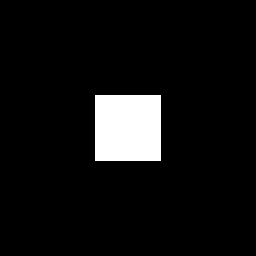

In [78]:
mask = np.zeros((256,256,3),dtype=np.uint8)
mask[95:161,95:161] = 255
mask = Image.fromarray(mask)
mask

In [77]:
n_mask = 100
first = '000000'
mask_format = '.png'
for i in range(n_mask):
    nb = str(i)
    nb_str = first[:-len(nb)] + nb
    mask.save(fp = mask_path+'/' + nb_str + mask_format)

In [3]:
print("Start", conf['name'])

device = dist_util.dev(conf.get('device'))


model, diffusion = create_model_and_diffusion(
    **select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
)


Start my_conf


In [4]:
model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)
model.to(device)
if conf.use_fp16:
    model.convert_to_fp16()
model.eval()

show_progress = conf.show_progress

import numpy as np
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Nombre de paramètres : ', params)

Nombre de paramètres :  552814086


In [ ]:
# https://colab.research.google.com/drive/12a_Wrfi2_gwwAuN3VvMTwVMz9TfqctNj#scrollTo=7zAqFEykBHDL TO DO

In [5]:

cond_fn = None

def model_fn(x, t, y=None, gt=None, **kwargs):
    assert y is not None
    return model(x, t, y if conf.class_cond else None, gt=gt)

In [6]:
dset = 'eval'

eval_name = conf.get_default_eval_name()

IMAGE_SIZE = 256
GT_PATH = './data/datasets/gts/face'
MASK_PATH = './data/datasets/gt_keep_masks/face'
dataconfig = {'mask_loader': True,
 'gt_path': GT_PATH,
 'mask_path': MASK_PATH,
 'image_size': IMAGE_SIZE,
 'class_cond': False,
 'deterministic': True, # Pas de shuffle dans le dataloader
 'random_crop': False, # Crop (au lieu de redimensionner l'image). Non Implémenté.
 'random_flip': False,
 'return_dict': True,
 'drop_last': False,
 'batch_size': 1,
 'return_dataloader': True,
 'offset': 0,
 'max_len': 8,
 'paths': {'srs': './log/face_example/inpainted',
  'lrs': './log/face_example/gt_masked',
  'gts': './log/face_example/gt',
  'gt_keep_masks': './log/face_example/gt_keep_mask'}
             }

conf['data']['eval'][eval_name] = dataconfig
dl = conf.get_dataloader(dset=dset, dsName=eval_name)
batch = next(iter(dl))

In [9]:
img = batch['GT'].to(device)
mask = batch['gt_keep_mask'].to(device)

img = torch.stack([img[0],img[0]])
mask = torch.stack([mask[0],mask[0]])

model_kwargs = {}
model_kwargs["gt"] = img
model_kwargs['y'] = 'SALUT LOLOL' #Utile seulement si conf.cond_y (voir model_fn au dessus). Doit être défini.
model_kwargs['gt_keep_mask'] = mask
model_kwargs['stop_to'] = 4000
model_kwargs['starting_point'] = None
batch_size = model_kwargs['gt'].shape[0]

sample_fn = (
    diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
)



In [21]:
time_pairs[4000]

(29, 28)

La configuration du dataset contient notamment les arguments utilisés par la classe ImageDatasetInpa (image_dataset.py dans le dossier guided_diffusion) pour retourner à partir du répertoire des images un dataset pytorch. Ce dataset est converti en dataloader avec la fonction DataLoader dans le même fichier.

Pour créer un dataset ImageDatasetInpa il faut la liste des imagages que l'on souhaite utiliser, et que l'on récupère avec la fonction _list_image_files_recursivcely.

In [10]:
return_all = False
result = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
    device=device,
    progress=show_progress,
    return_all=return_all,
    conf=conf
)


  0%|          | 0/4000 [00:00<?, ?it/s]

In [29]:
transform = T.ToPILImage()
def tou8batch(result,return_all=False):
    if return_all:
        finals = result[1]['sample']
    else:
        finals = result
    finals = ((finals + 1) * 127.5).clamp(0, 255).to(th.uint8)
    finals = finals.contiguous()
    return(finals)
y = tou8batch(result)

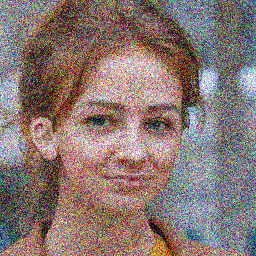

In [34]:
y = tou8batch(result)
transform(y[1])

In [ ]:
i=5
for sample in finals:
    img = transform(sample)
    img.save("images/sample_"+str(i)+".jpeg")
    i+=1

In [26]:
model_kwargs['stop_to'] = None
model_kwargs['starting_point'] = {'x':result,'step':4000}

In [27]:
return_all = False
result_bis = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
    device=device,
    progress=show_progress,
    return_all=return_all,
    conf=conf
)


  0%|          | 0/570 [00:00<?, ?it/s]

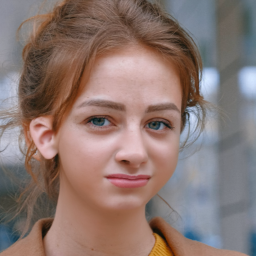

In [33]:
y = tou8batch(result_bis)
transform(y[1])

In [13]:
del result
torch.cuda.empty_cache()
!nvidia-smi

Wed Dec 21 16:40:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   27C    P8    10W / 200W |   3212MiB /  8192MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:





if conf.name=='my_conf':
    result = result[1] #0 is all tuples to generate gifs
srs = toU8(result['sample'])
gts = toU8(result['gt'])
lrs = toU8(result.get('gt') * model_kwargs.get('gt_keep_mask') + (-1) *
           th.ones_like(result.get('gt')) * (1 - model_kwargs.get('gt_keep_mask')))

gt_keep_masks = toU8((model_kwargs.get('gt_keep_mask') * 2 - 1))

conf.eval_imswrite(
    srs=srs, gts=gts, lrs=lrs, gt_keep_masks=gt_keep_masks,
    img_names=batch['GT_name'], dset=dset, name=eval_name, verify_same=False)

  0%|          | 0/4570 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
    srs = toU8(result[1]['sample'])
    gts = toU8(result[1]['gt'])
    lrs = toU8(result[1].get('gt') * model_kwargs.get('gt_keep_mask') + (-1) *
               th.ones_like(result[1].get('gt')) * (1 - model_kwargs.get('gt_keep_mask')))

    gt_keep_masks = toU8((model_kwargs.get('gt_keep_mask') * 2 - 1))

    conf.eval_imswrite(
        srs=srs, gts=gts, lrs=lrs, gt_keep_masks=gt_keep_masks,
        img_names=batch['GT_name'], dset=dset, name=eval_name, verify_same=False)

In [28]:
(1.33*4*33)

175.56

In [24]:
33*3

99